# 简要说明

## 关于代码

为了方便研究和演示, 这里的代码主要用使用了Python, 相关的API调用, 尽管Python和C/CPP有一定差别, 但由于底层调用的代码结构基本一致, 所以在了解了Python代码的原理和机制后, 也是可以容易迁移到C/CPP上.

## 关于CV的空间系
在上一章, 介绍了主要的颜色空间, 当我们从事图像学方面的分析工作时, 确定使用哪种图像空间是非常重要的步骤. 不过对于基本的图像操作来说, 一般以RGB/Gray空间为主, 所以如果文章里没有具体说明使用的颜色空间, 那么一般默认是RGB或者Gray.

OpenCV的颜色空间, 尤其是RGB空间, 与我们所熟知的有所不同, 它的定义是BGR, 也就是红蓝颜色的channel是对调的. 所以如果你是新手, 初学CV的话, 需要记住这一点. 另外CV的坐标定位, 跟硬件的定位是一致的, 也就是说在图形学领域、图像学领域使用的都是机器坐标. 也就是0点在左上角.

![在这里插入图片描述](https://img-blog.csdnimg.cn/20200804212505802.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)
 从左上角的0点, 垂直往下, 是高(height)——H方向, 水平往右是宽(width)——W方向. 因此一些图像的剪切、旋转、拼装, 都会在这个坐标系下进行. 如果你是第一次接触CV, 需要习惯与笛卡尔坐标所不同的基于硬件的坐标系统.  至于为什么以这么奇怪的方式定义像素坐标, 你可能需要参考一些计算机图形学方面的资料, 这里我不做过多的说明.

# 基础操作1: 通道分离

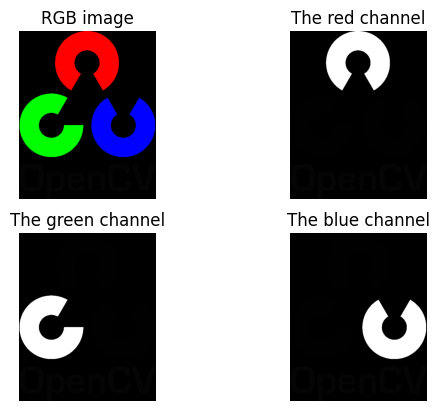

In [1]:
import cv2
import matplotlib.pyplot as plt

img_BGR = cv2.imread('/opt/images/opencv.png')  # BGR

# convert the BGR channels to the RGB format, for plotting
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# origianl image
plt.subplot(2, 2, 1); plt.imshow(img_RGB); plt.axis('off'); plt.title('RGB image')

# r channel
R = img_RGB[:, :, 0]
plt.subplot(2, 2, 2); plt.imshow(R, cmap="gray"); plt.axis('off'); plt.title('The red channel')

# g channel
G = img_RGB[:, :, 1]
plt.subplot(2, 2, 3); plt.imshow(G, cmap="gray"); plt.axis('off'); plt.title('The green channel')

# b channel
B = img_RGB[:, :, 2]
plt.subplot(2, 2, 4); plt.imshow(B, cmap="gray"); plt.axis('off'); plt.title('The blue channel')

# show the results
plt.show()

# 基础操作2: 通道合并

通道合并也是常用的基本操作, 尤其是当你需要对数据进行单通道处理后, 需要重新组合成新的图片, 这是一个很常见的操作.

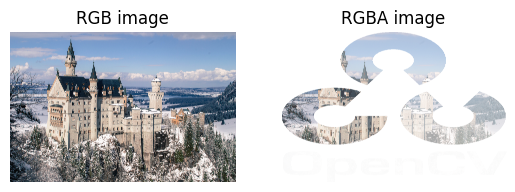

In [2]:
import cv2
import matplotlib.pyplot as plt

bgr_img = cv2.imread("/opt/images/castle.png", cv2.IMREAD_COLOR)
gray_img = cv2.imread("/opt/images/opencv.png", cv2.IMREAD_GRAYSCALE)

# convert the gray image's size to the target size
gray_img = cv2.resize(gray_img, (bgr_img.shape[1], bgr_img.shape[0]), interpolation=cv2.INTER_CUBIC)

# split the bgr channels
B, G, R = cv2.split(bgr_img)

# create a new image with alpha channel
bgr_new = cv2.merge((B, G, R, gray_img))

# do something more before plotting with plt
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
rgba_new = cv2.cvtColor(bgr_new, cv2.COLOR_BGRA2RGBA)

plt.subplot(1, 2, 1); plt.imshow(rgb_img); plt.axis('off'); plt.title('RGB image')
plt.subplot(1, 2, 2); plt.imshow(rgba_new); plt.axis('off'); plt.title('RGBA image')

plt.show()

# 基础操作3: 图像拼接

图像拼接也是非常基本的操作, 需要注意的是图像拼接的顺序, 以及图像延展方向, 这里以向右拼接为例:

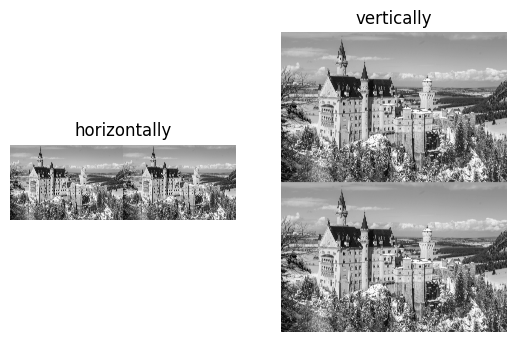

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# load image as a gray scale image
img_gray = cv2.imread("/opt/images/castle.png", cv2.IMREAD_GRAYSCALE)
img_copy = img_gray.copy()

# concatenate two images by horizontally and vertically
horizon = np.concatenate((img_gray, img_copy), axis=1)
vertical = np.concatenate((img_gray, img_copy), axis=0)

# plot images
plt.subplot(1, 2, 1); plt.imshow(horizon, cmap="gray"); plt.axis('off'); plt.title('horizontally')
plt.subplot(1, 2, 2); plt.imshow(vertical, cmap="gray"); plt.axis('off'); plt.title('vertically')

plt.show()

# 基础操作4: 图像剪切

之前的几个操作, 实际上最多只到像素级的操作, 也就是CV进行单纯的内存操作. 而要开始实现图像的变换, 例如剪切、压缩、变大等工作, 需要一些矩阵的相关知识. 只不过对于我们调用API而言, 并不需要了解太多, 如果你有兴趣可以尝试自己手写矩阵计算, 为了节省点篇幅(实际上就是写到这里有点累, 想鸽了...)

图像的剪切, 通常会引入一个叫做掩码矩阵的东西, 有点像这个样子:

$$
M^* = \begin{bmatrix}
1 & 1 & 0 & \cdots \\ 
1 & 1 & 0 & \cdots \\ 
0 & 0 & 0 & \cdots \\ 
\cdots & \cdots  & \cdots & \cdots
\end{bmatrix} \cdot M
$$

掩码矩阵是一个包含0/1的矩阵, 大小和原始矩阵M的维度一样, 进行元素乘积(矩阵点乘) , 然后将得到的新矩阵$M^*$去掉不需要的部分, 于是得到剪切后的图像. 

**当然, 我们也可以更简单一点, 直接读取我们需要的像素信息即可.**

对于CV代码来说, 这个步骤非常简单:

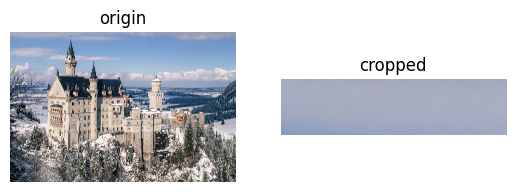

In [4]:
import cv2
import matplotlib.pyplot as plt

origin = cv2.imread("/opt/images/castle.png")

# convert the BGR to RGB
origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)

# crop a piece from origin image
cropped = origin[0:128, 0:512]  # 裁剪坐标为[y0:y1, x0:x1]

# show the images
plt.subplot(1, 2, 1); plt.imshow(origin); plt.axis('off'); plt.title('origin')
plt.subplot(1, 2, 2); plt.imshow(cropped); plt.axis('off'); plt.title('cropped')
plt.show()


# 基础操作5: 图像旋转

关于三维空间中如何进行旋转, 可以看一看这位的资料, 我个人觉得写的很不错, [《旋转变换》](https://blog.csdn.net/csxiaoshui/article/details/65446125)

## 绕原点的二维旋转矩阵

$$
M^* = \begin{bmatrix}
cos \theta & -sin \theta & 0\\ 
sin \theta & cos \theta & 0 \\
0 & 0 & 1 
\end{bmatrix} * \begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$

但是如果扩展到三维空间中, 针对X、Y、Z轴的笛卡尔坐标变换时, 旋转矩阵就是这样了:

## 绕X轴旋转的三维旋转矩阵

$$
M^* = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & cos \theta & -sin \theta & 0 \\
0 & sin \theta & cos \theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} * \begin{bmatrix}
x \\ 
y \\
z \\
1
\end{bmatrix}
$$

这里的 $\theta$ 是roll角, 在yz平面上, 和右手螺旋的方向相反.

## 绕Y轴旋转的三维旋转矩阵
$$
M^* = \begin{bmatrix}
cos \theta & 0 & sin \theta & 0 \\
0 & 1 & 0 & 0 \\
-sin \theta & 0 & cos \theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} * \begin{bmatrix}
x \\ 
y \\
z \\
1
\end{bmatrix}
$$

这里的 $\theta$ 是pitch角, 在xz平面上, 和右手螺旋的方向相反.

## 绕Z轴旋转的三维旋转矩阵

$$
M^* = \begin{bmatrix}
cos \theta & -sin \theta & 0 & 0 \\
sin \theta & cos \theta & 0 & 0 \\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix} * \begin{bmatrix}
x \\ 
y \\
z \\
1
\end{bmatrix}
$$

这里的 $\theta$ 是yaw角, 在xy平面上, 和右手螺旋的方向相反. 当然, 对于CV来说, 你可以完全不Care这个怎么实现的, 我们只需要学会调用几个API就可以了.

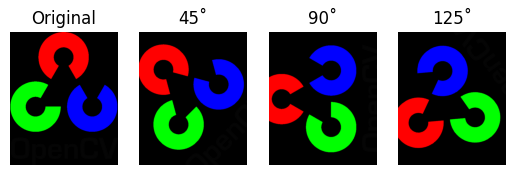

In [5]:
import cv2
import matplotlib.pyplot as plt


def rotate(image, angle, center=None, scale=1.0):
    # get the image size
    h, w, _ = image.shape

    # default: set w/2 and h/2 as the center pt
    if center is None:
        center = (w / 2, h / 2)

    # calculate the rotation matrix
    rotated_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    # apply with the rotation matrix
    rotated_image = cv2.warpAffine(image, rotated_matrix, (w, h))

    # return to caller
    return rotated_image


def show_image(image, title, pos):
    plt.subplot(1, 4, pos);
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)


# load image from the src
logo = cv2.imread("/opt/images/opencv.png")

# convert to RGB first
logo = cv2.cvtColor(logo, cv2.COLOR_BGR2RGB)

# rotate the image by 45, 90, 125 degrees
show_image(logo, "Original", 1)
show_image(rotate(logo, 45), "45˚", 2)
show_image(rotate(logo, 90), "90˚", 3)
show_image(rotate(logo, 125), "125˚", 4)

# show the results
plt.show()

# 基础操作6: 图片变形

通常这一步指的是对图像的压缩和放大, 可以等比或不等比. 使用的是缩放矩阵. 缩放矩阵是一种对平移矩阵的扩展, 我们先来看一下平移矩阵的形式:

 $$
\begin{bmatrix}
1 & 0 & 0 & V_X \\
0 & 1 & 0 & V_y \\
0 & 0 & 1 & V_z \\
0 & 0 & 0 & 1
\end{bmatrix} * \begin{bmatrix}
x \\ 
y \\
z \\
1
\end{bmatrix} = \begin{bmatrix}
V_x + x \\ 
V_y + y \\
V_z + z \\
1
\end{bmatrix}
$$

这里的 $\vec{V} = (V_x, V_y, V_z)$ 是平移向量. 缩放矩阵的变化, 主要就是在对角线1上进行变化, 因此:
 
$$
\begin{bmatrix}
a & 0 & 0 & 0 \\
0 & b & 0 & 0 \\
0 & 0 & c & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} * \begin{bmatrix}
x \\ 
y \\
z \\
1
\end{bmatrix} = \begin{bmatrix}
ax \\ 
by \\
cz \\
1
\end{bmatrix}
$$

因此, 如果a, b, c大于了1, 那么就是放大矩阵, 如果小于1就是压缩矩阵了. 如果不仅对图像进行缩放, 也要同时进行平移, 那么矩阵就变成了:

$$
\begin{bmatrix}
a & 0 & 0 & V_x \\
0 & b & 0 & V_y \\
0 & 0 & c & V_z \\
0 & 0 & 0 & 1
\end{bmatrix} * \begin{bmatrix}
x \\ 
y \\
z \\
1
\end{bmatrix} = \begin{bmatrix}
ax + V_x \\ 
by + V_y \\
cz + V_z \\
1
\end{bmatrix}
$$

这种缩放是针对矢量图的, 但是对于像素点的缩放, 还需要引入一个叫做插值的概念. 关于**插值**这里引用一下百度百科的说法:

	在离散数据的基础上补插连续函数，使得这条连续曲线通过全部给定的离散数据点。 
	插值是离散函数逼近的重要方法，利用它可通过函数在有限个点处的取值状况，估算出函数在其他点处的近似值。

因此, 我们可以知道, 插值只是一种估计方法, 这也就是为什么栅格化的像素图, 经过放大或者缩小后, 会出现失真模糊的问题. 

通常情况下, 我们比较常用的有线性插值、Hermit插值, 样条插值等,   OpenCV都提供了相关的插值方法, 你可以自己选取喜欢的进行尝试. 只不过需要指出的, 插值函数越复杂, 计算所消耗的时间也就越多, 在某些情况下, 你需要进行适当的取舍.

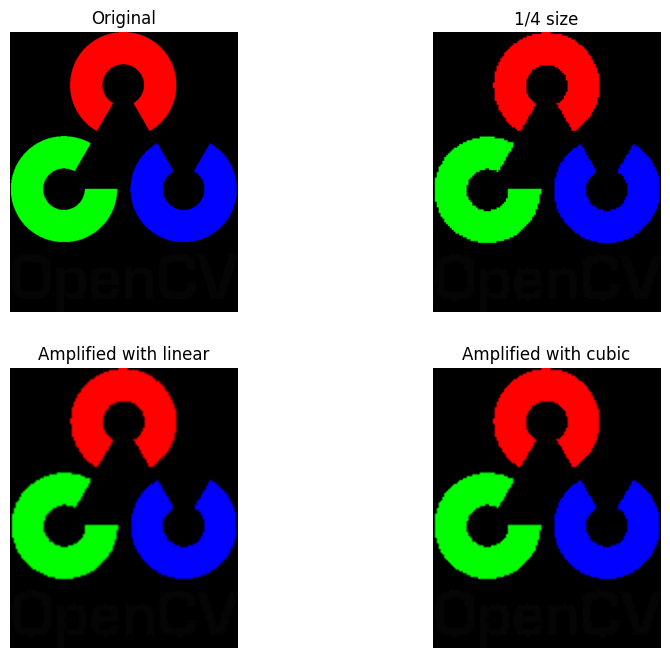

In [6]:
import cv2
import matplotlib.pyplot as plt

def reshape_image(image):
    plt.figure(figsize=(10, 8))

    # Show original image
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    # Shrink to its half size
    shrunk_image = cv2.resize(image, (0, 0), fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(shrunk_image, cv2.COLOR_BGR2RGB))
    plt.title("1/4 size")
    plt.axis('off')

    # Amplify the image with linear interpolation method
    amplified_1 = cv2.resize(shrunk_image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(amplified_1, cv2.COLOR_BGR2RGB))
    plt.title("Amplified with linear")
    plt.axis('off')

    # Amplify the image with cubic interpolation method
    amplified_2 = cv2.resize(shrunk_image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(amplified_2, cv2.COLOR_BGR2RGB))
    plt.title("Amplified with cubic")
    plt.axis('off')

# Load image from src
fp = cv2.imread("/opt/images/opencv.png")

# Reshape the images
reshape_image(fp)

# Plot results
plt.show()